# Mapping problem using moscot  
from dissociated scRNAseq data to spatial data 

### Import packages

In [1]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [3]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [4]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [5]:
adata_sp.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

In [6]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Ductal',
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sc.obs['cell_type'] = adata_sc.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sc.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [7]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Pseudobulk dissociated data

In [8]:
adatas_sc_pb = []
for ct in adata_sc.obs.cell_type.unique():
    cell_subset = adata_sc[adata_sc.obs['cell_type'] == ct]
    
    cell_subset.X = cell_subset.layers['counts'] #make sure to use raw data
    
    rep_adata = sc.AnnData(X = cell_subset.X.sum(axis = 0),
                           var = cell_subset.var[[]])
    
    rep_adata.obs_names = [ct]
    
    adatas_sc_pb.append(rep_adata)

In [9]:
adata_sc_pb = sc.concat(adatas_sc_pb)
adata_sc_pb

AnnData object with n_obs × n_vars = 8 × 5000

In [10]:
adata_sc_pb.obs['cell_type'] = pd.Categorical(['Acinar', 'Ductal', 'Fibroblasts', 'Beta', 'Alpha', 'Endocrine',
       'Immune', 'Endothelial'])

In [11]:
adata_sc_pb.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

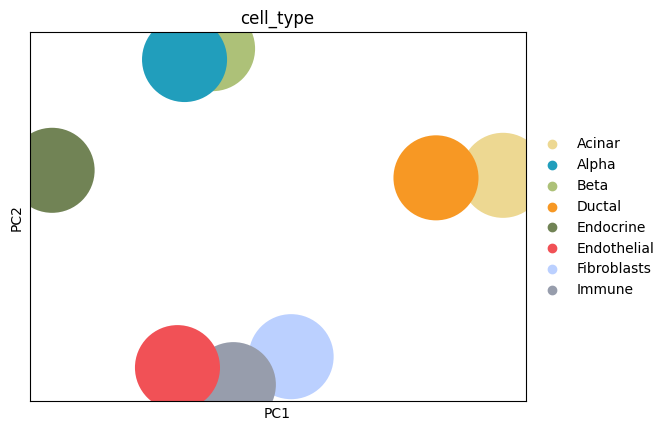

In [12]:
adata_sc_pb.X = np.array(adata_sc_pb.X)
sc.pp.log1p(adata_sc_pb)
sc.pp.pca(adata_sc_pb)
sc.pl.pca(adata_sc_pb,color='cell_type')

Subset to a field of view to test the mapping problem 

In [13]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [14]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)

Normalization to avoid technical artifacts (has to be per fov)

In [15]:
spatial = adata_sp_fov_12.obsm['spatial']
adata_sp_fov_12.obsm['spatial_norm'] = spatial - spatial.mean() / spatial.std()
adata_sp_fov_12.obsm['PCA_spatial'] = np.concatenate([adata_sp_fov_12.obsm['spatial_norm'], adata_sp_fov_12.obsm['X_pca']], axis = 1)

### Preprare and solve the mapping problem parameter tunning

In [16]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [17]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [52]:
len(genes2impute)

48

In [53]:
sc.pl.dotplot

<function scanpy.plotting._dotplot.dotplot(adata: 'AnnData', var_names: '_VarNames | Mapping[str, _VarNames]', groupby: 'str | Sequence[str]', *, use_raw: 'bool | None' = None, log: 'bool' = False, num_categories: 'int' = 7, expression_cutoff: 'float' = 0.0, mean_only_expressed: 'bool' = False, cmap: 'str' = 'Reds', dot_max: 'float | None' = None, dot_min: 'float | None' = None, standard_scale: "Literal['var', 'group'] | None" = None, smallest_dot: 'float | None' = 0.0, title: 'str | None' = None, colorbar_title: 'str | None' = 'Mean expression\nin group', size_title: 'str | None' = 'Fraction of cells\nin group (%)', figsize: 'tuple[float, float] | None' = None, dendrogram: 'bool | str' = False, gene_symbols: 'str | None' = None, var_group_positions: 'Sequence[tuple[int, int]] | None' = None, var_group_labels: 'Sequence[str] | None' = None, var_group_rotation: 'float | None' = None, layer: 'str | None' = None, swap_axes: 'bool | None' = False, dot_color_df: 'pd.DataFrame | None' = None

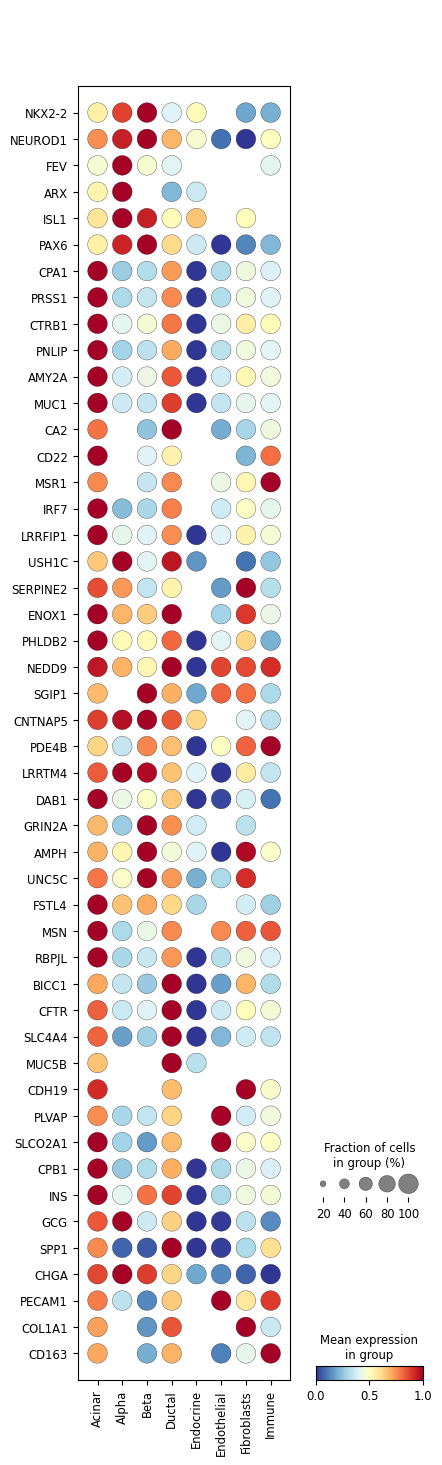

In [56]:
sc.pl.dotplot(adata_sc_pb, var_names=genes2impute,groupby='cell_type',standard_scale='var',
             cmap='RdYlBu_r',swap_axes=True)

In [18]:
# Leave the control genes out of the fitting
adata_sp_fov_12_mp = adata_sp_fov_12[:,~adata_sp_fov_12.var_names.isin(markers2impute)].copy()

In [19]:
params = {
    'epsilon': [0.001,0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [1, 0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [1, 0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [20]:
from sklearn.metrics import f1_score

In [22]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=adata_sc_pb, adata_sp=adata_sp_fov_12_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
                    cost = 'sq_euclidean', #'sq_euclidean', 
                    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through annotation mapping 
                anno_map_max = mp.annotation_mapping("max","cell_type",source="src",forward=False,batch_size=256)
                adata_sp_fov_12_mp.obs["cell_type_max"] = anno_map_max["cell_type"].values
                adata_sp_fov_12_mp.obs["cell_type_max"] = adata_sp_fov_12_mp.obs["cell_type_max"].astype("category")

                pred_ann = adata_sp_fov_12_mp.obs["cell_type_max"].cat.categories.unique()
                adata_sp_fov_12_cmp = adata_sp_fov_12_mp[adata_sp_fov_12_mp.obs.cell_type_coarse.isin(pred_ann),:].copy()

                y_true = np.array(adata_sp_fov_12_cmp.obs["cell_type_coarse"])
                y_pred = np.array(adata_sp_fov_12_cmp.obs["cell_type_max"])
                
                f1 = f1_score(y_true, y_pred, average = 'weighted')
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'ct_true' : y_true,
                    'ct_pred' : y_pred,
                    'F1 score' : f1
                }
                evaluation.append(row_data)
                del mp
df = pd.DataFrame(evaluation)
df

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 8)].                                             
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 8)].  

,tau_a,tau_b,alpha,epsilon,ct_true,ct_pred,F1 score
0,1.0,1.0,0.2,0.001,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Ducta...",0.216911
1,1.0,1.0,0.2,0.010,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Ducta...",0.217534
2,1.0,1.0,0.2,0.050,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Ducta...",0.219475
3,1.0,1.0,0.2,0.100,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Ducta...",0.222752
4,1.0,1.0,0.3,0.001,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Ducta...",0.214836
...,...,...,...,...,...,...,...
395,0.9,0.9,0.4,0.100,"[Acinar, Acinar, Ductal, Ductal, Ductal, Acina...","[Acinar, Acinar, Ductal, Ductal, Ductal, Fibro...",0.120516
396,0.9,0.9,0.5,0.001,"[Acinar, Acinar, Acinar, Acinar, Acinar, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Acina...",1.000000
397,0.9,0.9,0.5,0.010,"[Acinar, Acinar, Acinar, Acinar, Acinar, Acina...","[Acinar, Acinar, Acinar, Acinar, Acinar, Acina...",1.000000
398,0.9,0.9,0.5,0.050,"[Ductal, Ductal, Ductal, Ductal, Fibroblasts, ...","[Fibroblasts, Immune, Immune, Endothelial, End...",0.133811


In [24]:
df.to_csv('pseudobulk_sq_euclidean_joint_attr_X_ct.csv', sep='\t', index=False)

In [23]:
# Find the index label corresponding to the maximum value in a specific column
max_index = df['F1 score'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values = df.loc[max_index]

# Print the values
print(max_row_values)

tau_a                                                   0.999
tau_b                                                   0.999
alpha                                                     0.2
epsilon                                                 0.001
ct_true     [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...
ct_pred     [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...
F1 score                                                  1.0
Name: 96, dtype: object


### Analysis of the transport plan with the best set of found parameters

In [25]:
best_param = max_row_values.to_dict()
best_param

{'tau_a': 0.999,
 'tau_b': 0.999,
 'alpha': 0.2,
 'epsilon': 0.001,
 'ct_true': array(['Acinar', 'Acinar', 'Acinar', ..., 'Acinar', 'Acinar', 'Acinar'],
       dtype=object),
 'ct_pred': array(['Acinar', 'Acinar', 'Acinar', ..., 'Acinar', 'Acinar', 'Acinar'],
       dtype=object),
 'F1 score': 1.0}

In [26]:
mp = MappingProblem(adata_sc=adata_sc_pb, adata_sp=adata_sp_fov_12_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
    cost = 'sq_euclidean', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 8)].                                             
WARNING  Solver did not converge                                                                                   


#### Imputation

In [27]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(adata_sc_pb.var_names)/20)):
    adata_imputed = mp.impute(var_names=adata_sc_pb.var_names[i*20:i*20+20],device='cpu')#device='cuda:0'
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 21.315658569335938 seconds


In [28]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000

In [29]:
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'd

In [30]:
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [31]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

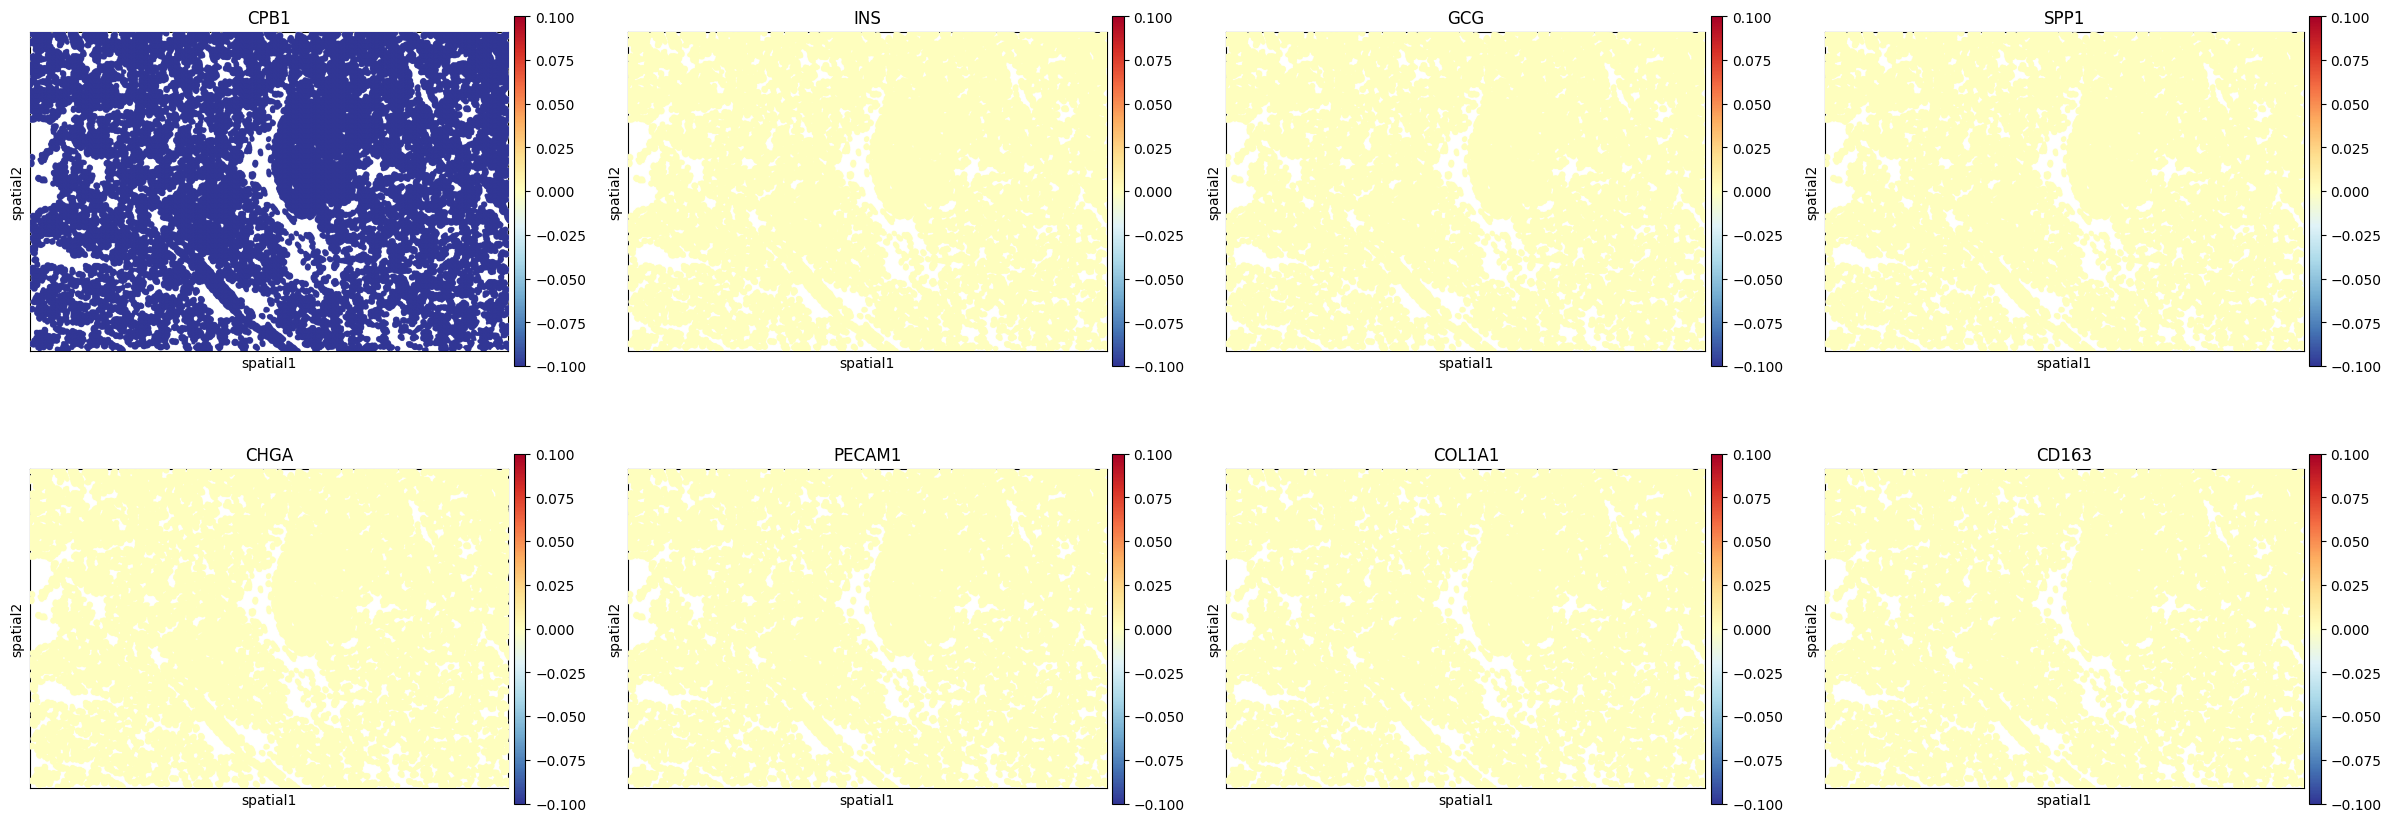

In [33]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

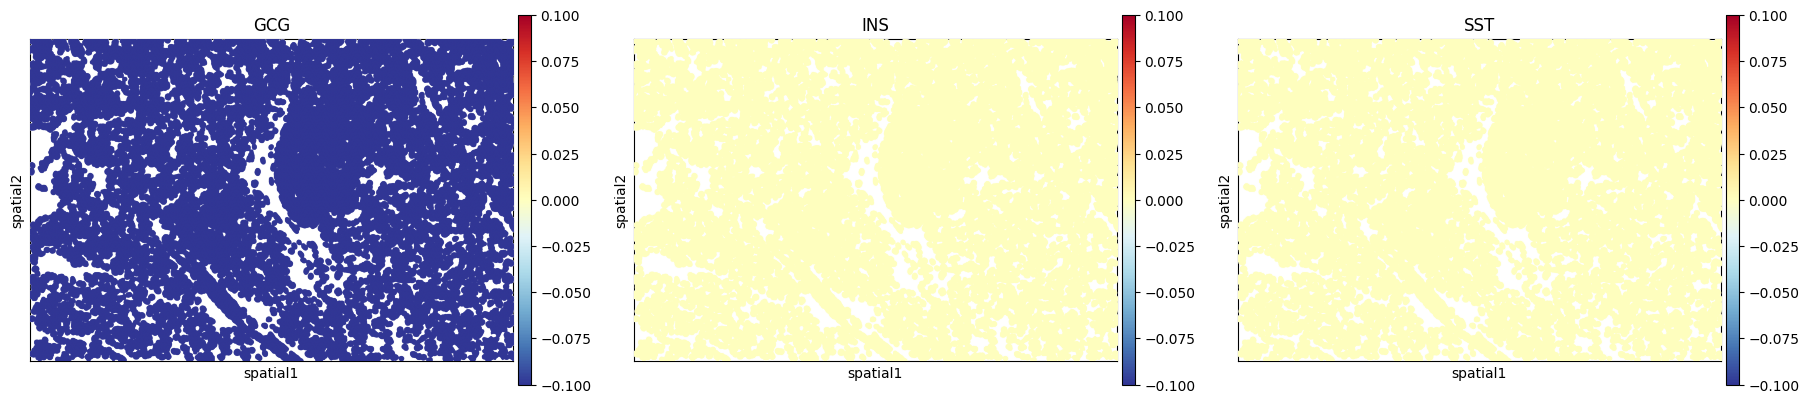

In [34]:
sq.pl.spatial_segment(adata_imputed,color=['GCG','INS','SST'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Plotting observed gene expression for hallmark hormone genes

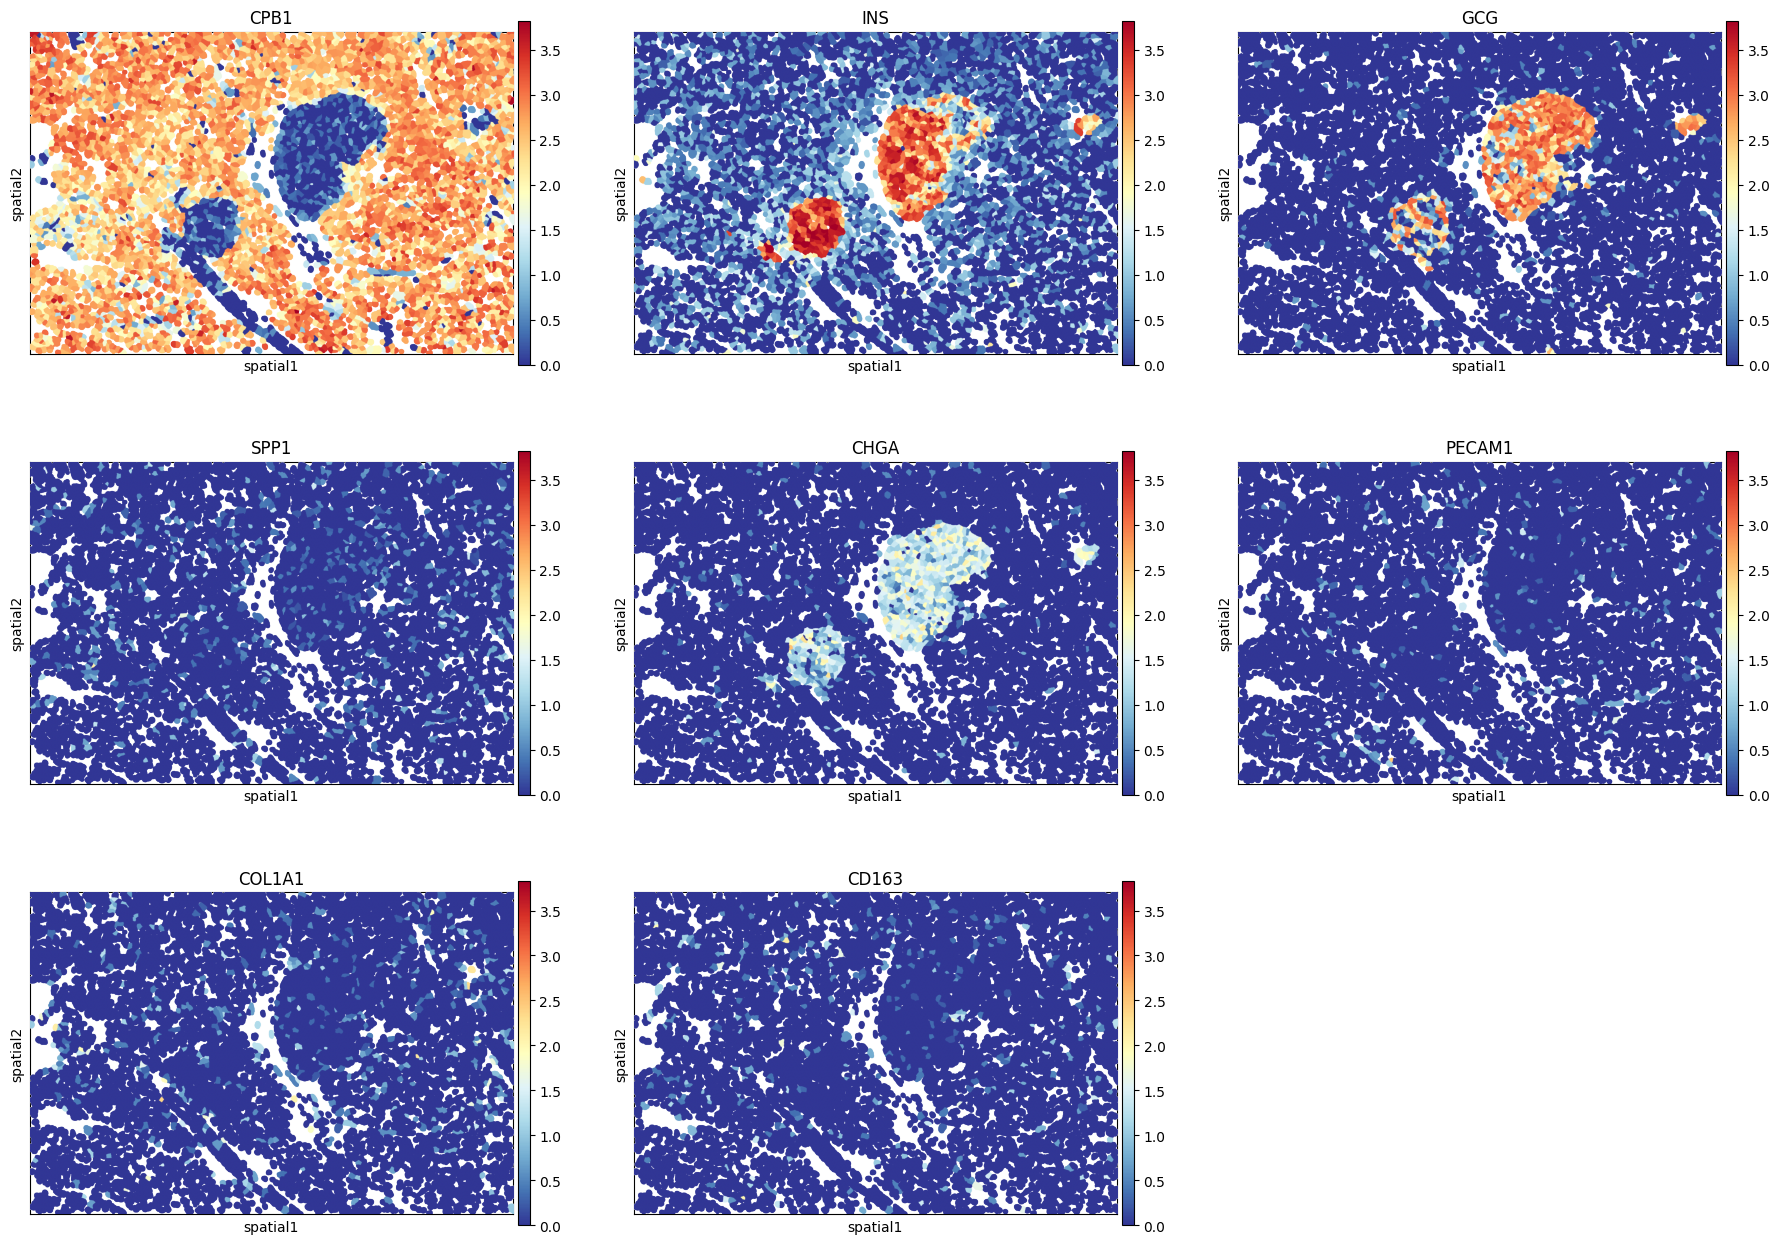

In [35]:
sq.pl.spatial_segment(adata_sp_fov_12,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [36]:
adata_sp_fov_12, adata_imputed

(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
     varm: 'PCs'
     layers: 'counts'
     

In [37]:
adata_imputed.obs['cell_type_coarse'] = adata_sp_fov_12.obs['cell_type_coarse']

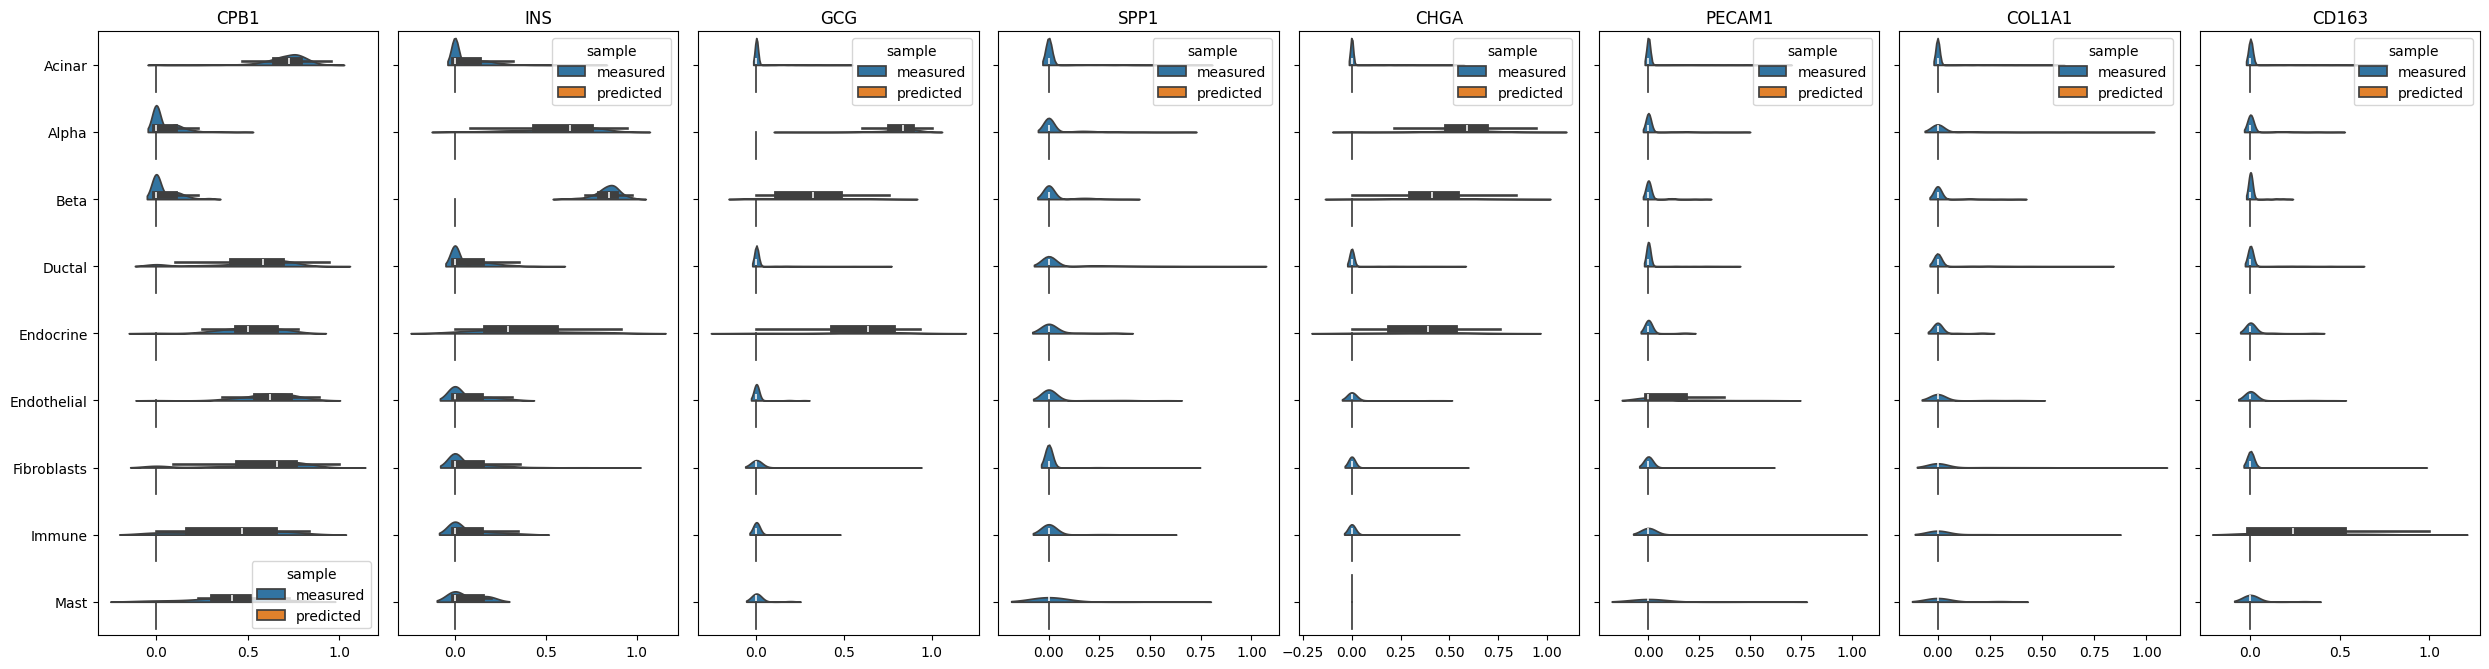

In [38]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type_coarse"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()

#### Annotation mapping

In [39]:
mp[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 8)]

In [40]:
type(adata_sc_pb.obs.cell_type)

pandas.core.series.Series

In [41]:
adata_sc_pb.obs.cell_type = adata_sc_pb.obs.cell_type.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

Annotation mapping using “max” mode

In [42]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "cell_type",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 2.226943254470825 seconds


In [43]:
adata_sp_fov_12.obs["cell_type_max"] = anno_map_max["cell_type"].values
adata_sp_fov_12.obs["cell_type_max"] = adata_sp_fov_12.obs["cell_type_max"].astype("category")

In [44]:
adata_sp_fov_12.uns['cell_type_max_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

In [45]:
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type_max'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'cell_type_max_colors'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
    varm

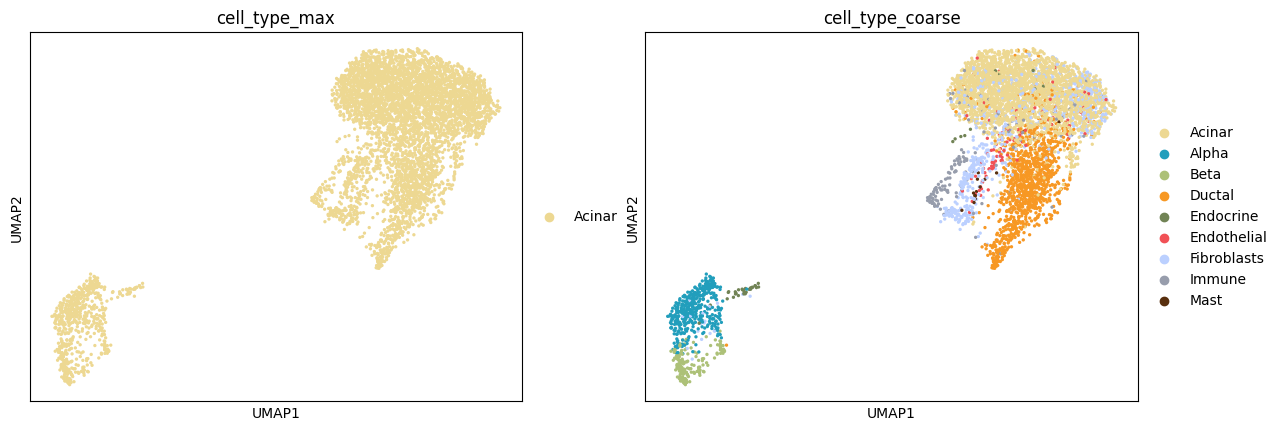

In [46]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max",'cell_type_coarse'])

In [ ]:
sq.pl.spatial_segment(adata_sp_fov_12,color='cell_type_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Annotation mapping using the “sum” mode

In [47]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "cell_type",
    source="src",
    forward=False,
    batch_size=1,
)
adata_sp_fov_12.obs["cell_type_sum"] = anno_map_sum["cell_type"].values
adata_sp_fov_12.obs["cell_type_sum"] = adata_sp_fov_12.obs["cell_type_sum"].astype("category")

In [48]:
adata_sp_fov_12.uns['cell_type_sum_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

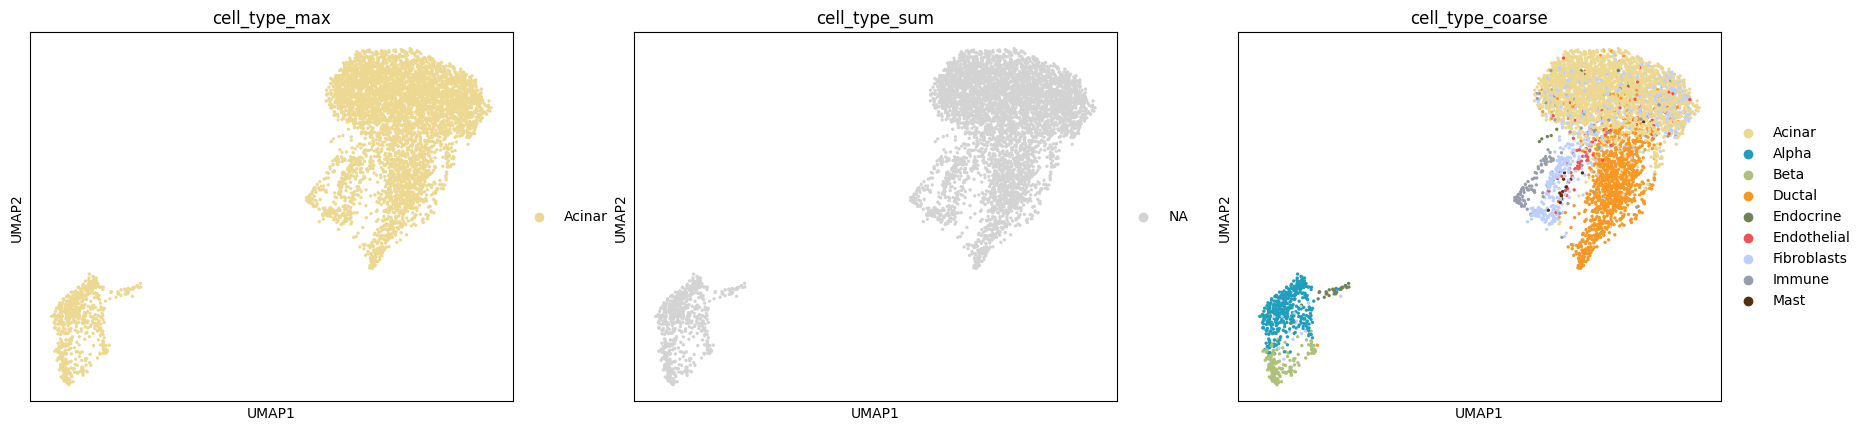

In [49]:
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max", "cell_type_sum","cell_type_coarse"])

In [50]:
adata_sp_fov_12[adata_sp_fov_12.obs["cell_type_max"] == adata_sp_fov_12.obs["cell_type_sum"]].shape[
    0
] / adata_sp_fov_12.shape[0]

TypeError: Categoricals can only be compared if 'categories' are the same.

In [ ]:
adata_sp_fov_12_cmp = adata_sp_fov_12[~adata_sp_fov_12.obs.cell_type_coarse.isin(['Mast']),:].copy()
adata_sp_fov_12_cmp

In [ ]:
adata_sp_fov_12_cmp[adata_sp_fov_12_cmp.obs["cell_type_max"] == adata_sp_fov_12_cmp.obs["cell_type_coarse"]].shape[
    0
] / adata_sp_fov_12_cmp.shape[0]

In [ ]:
adata_sp_fov_12_cmp[adata_sp_fov_12_cmp.obs["cell_type_sum"] == adata_sp_fov_12_cmp.obs["cell_type_coarse"]].shape[
    0
] / adata_sp_fov_12_cmp.shape[0]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_true = np.array(adata_sp_fov_12_cmp.obs["cell_type_coarse"])
y_pred = np.array(adata_sp_fov_12_cmp.obs["cell_type_sum"])

f1 = f1_score(y_true, y_pred, average = 'weighted')

print("F1 score:", f1)

In [ ]:
np.array(adata_sp_fov_12_cmp.obs["cell_type_sum"])